# <center>Рекомендательная система на основе эмбеддингов для датасета MovieLens</center>

# Модели на основе обучаемых эмбеддингов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model, layers, Sequential
from tensorflow.keras.optimizers.legacy import Adam

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
movies_df = pd.read_csv("ml-latest\movies_mod.csv", index_col='movieId')
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,3.891454,0.917794,2469.0
2,Jumanji,1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3.231282,0.959175,975.0
3,Grumpier Old Men,1995,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,3.190355,0.999860,591.0
4,Waiting to Exhale,1995,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,2.995902,1.031520,122.0
5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,3.032907,1.034132,547.0


In [5]:
ratings_df = pd.read_csv(r"ml-latest\ratings.csv").iloc[:100_000]
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
genome = pd.read_csv(r"ml-latest\genome-pivot.csv", index_col='movieId')
genome.head()

,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02900,0.02375,0.05425,0.06875,0.16000,0.19525,0.07600,0.25200,0.22750,0.02400,...,0.03775,0.02250,0.04075,0.03175,0.12950,0.04550,0.02000,0.03850,0.09125,0.02225
2,0.03625,0.03625,0.08275,0.08175,0.10200,0.06900,0.05775,0.10100,0.08225,0.05250,...,0.04775,0.02050,0.01650,0.02450,0.13050,0.02700,0.01825,0.01225,0.09925,0.01850
3,0.04150,0.04950,0.03000,0.09525,0.04525,0.05925,0.04000,0.14150,0.04075,0.03200,...,0.05800,0.02375,0.03550,0.02125,0.12775,0.03250,0.01625,0.02125,0.09525,0.01750
4,0.03350,0.03675,0.04275,0.02625,0.05250,0.03025,0.02425,0.07475,0.03750,0.02400,...,0.04900,0.03275,0.02125,0.03675,0.15925,0.05225,0.01500,0.01600,0.09175,0.01500
5,0.04050,0.05175,0.03600,0.04625,0.05500,0.08000,0.02150,0.07375,0.02825,0.02375,...,0.05375,0.02625,0.02050,0.02125,0.17725,0.02050,0.01500,0.01550,0.08875,0.01575


## Создание датасета для обучения

In [7]:
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df = pd.merge(ratings_df, movies_df, how='left', left_on='movieId', right_on='movieId')
ratings_df = ratings_df.drop('title', axis=1)
ratings_df['rating'] = (ratings_df['rating'] - 0.5)/4.5
ratings_df.head()

,userId,movieId,rating,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
0,1,307,0.666667,1993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.036164,0.959485,318.0
1,1,481,0.666667,1993,0,0,0,0,0,0,...,0,0,1,0,0,0,0,3.371542,0.886573,253.0
2,1,1091,0.222222,1989,0,0,0,0,1,0,...,0,0,0,0,0,0,0,2.815421,1.122663,214.0
3,1,1257,0.888889,1985,0,0,0,0,1,0,...,1,0,0,0,0,0,0,3.799550,0.921905,222.0
4,1,1449,0.888889,1996,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3.916667,0.974243,246.0


In [8]:
X = ratings_df.drop('rating', axis=1)
X

,userId,movieId,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Romance,Sci-Fi,Thriller,War,Western,(no genres listed),IMAX,rating_mean,rating_std,rating_count
0,1,307,1993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.036164,0.959485,318.0
1,1,481,1993,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,3.371542,0.886573,253.0
2,1,1091,1989,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2.815421,1.122663,214.0
3,1,1257,1985,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,3.799550,0.921905,222.0
4,1,1449,1996,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,3.916667,0.974243,246.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1041,1393,1996,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,3.609509,0.932208,936.0
99996,1041,1411,1996,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,3.678138,1.004385,247.0
99997,1041,1419,1971,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,3.833333,0.988264,51.0
99998,1041,1446,1996,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,4.058824,0.874274,85.0


In [9]:
y = ratings_df['rating']
y

0        0.666667
1        0.666667
2        0.222222
3        0.888889
4        0.888889
           ...   
99995    0.777778
99996    0.777778
99997    0.555556
99998    0.777778
99999    0.777778
Name: rating, Length: 100000, dtype: float64

In [10]:
ratings_df = ratings_df[['userId', 'movieId', 'rating']]
ratings_df = pd.merge(ratings_df, genome, how='inner', left_on='movieId', right_on='movieId')
ratings_df.head()

,userId,movieId,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,1,307,0.666667,0.02025,0.01975,0.07075,0.06975,0.04925,0.05175,0.0435,...,0.05975,0.02825,0.017,0.07925,0.17325,0.068,0.03925,0.00725,0.073,0.0185
1,6,307,0.777778,0.02025,0.01975,0.07075,0.06975,0.04925,0.05175,0.0435,...,0.05975,0.02825,0.017,0.07925,0.17325,0.068,0.03925,0.00725,0.073,0.0185
2,56,307,0.777778,0.02025,0.01975,0.07075,0.06975,0.04925,0.05175,0.0435,...,0.05975,0.02825,0.017,0.07925,0.17325,0.068,0.03925,0.00725,0.073,0.0185
3,71,307,1.000000,0.02025,0.01975,0.07075,0.06975,0.04925,0.05175,0.0435,...,0.05975,0.02825,0.017,0.07925,0.17325,0.068,0.03925,0.00725,0.073,0.0185
4,84,307,0.555556,0.02025,0.01975,0.07075,0.06975,0.04925,0.05175,0.0435,...,0.05975,0.02825,0.017,0.07925,0.17325,0.068,0.03925,0.00725,0.073,0.0185


In [11]:
X_genome = ratings_df.drop('rating', axis=1)
y_genome = ratings_df.rating

Для валидации оставляем 10 процентов датасета (т.к. данных достаточно много)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, shuffle=True)

In [13]:
X_train_autoenc, X_valid_autoenc, _, _ = train_test_split(genome.values, genome.values, test_size=0.1, shuffle=True)

In [14]:
X_train_genome, X_valid_genome, y_train_genome, y_valid_genome = train_test_split(X_genome, y_genome, test_size=0.10, shuffle=True)

## Модель с эмбеддингами на основе id 

In [108]:
def id_embedding_model(num_users, num_movies, rows_count, emb_size):
    movie_input = Input(shape=(1,), name='movie_id')
    movie_emb = layers.Embedding(output_dim=emb_size, input_dim=num_movies+1, input_length=rows_count+1, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='movie_emb_flatten')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)

    user_input = Input(shape=(1,), name='user_id')
    user_emb = layers.Embedding(output_dim=emb_size, input_dim=num_users+1, input_length=rows_count+1, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='user_emb_flatten')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)

    merged = layers.Dot(name = 'dot_product', normalize = True, axes=1)([movie_vec, user_vec])
    merged_dropout = layers.Dropout(0.2)(merged)


    dense_1 = layers.Dense(128,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout-1')(dense_1)

    dense_2 = layers.Dense(64,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout-2')(dense_2)

    dense_3 = layers.Dense(16,name='FullyConnected-3')(dropout_2)
    dropout_3 = layers.Dropout(0.2,name='Dropout-3')(dense_3)

    dense_4 = layers.Dense(4,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="sigmoid")(dense_4)

    adam = Adam(learning_rate=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam, loss= 'mean_absolute_error', metrics='mean_squared_error')
    return movie_model, user_model, model

In [109]:
id_movie_model, id_user_model, id_model = id_embedding_model(X.userId.nunique(), movies_df.index.max(), ratings_df.shape[0], 32)

**Схема модели**

<div>
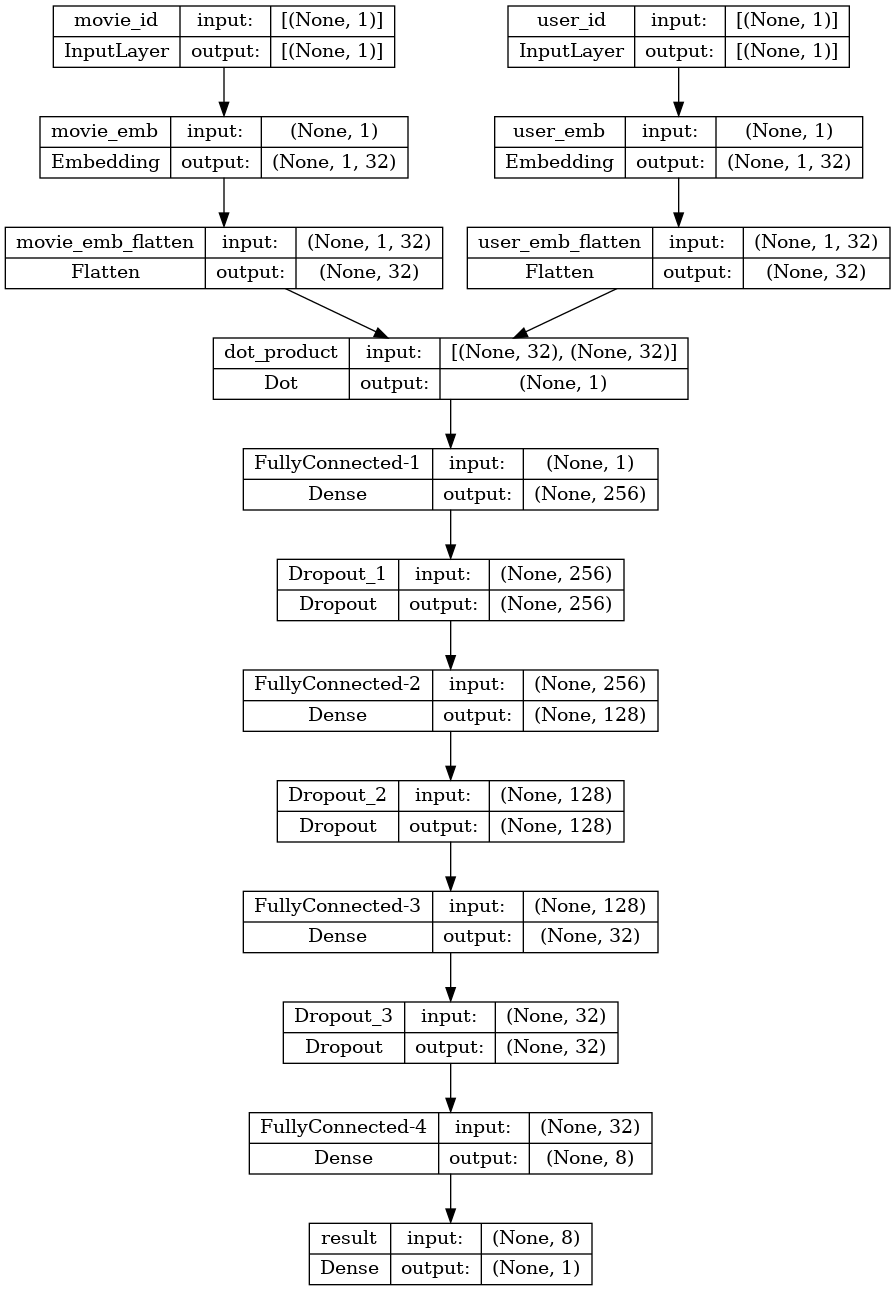
</div>

Модель состоит из трёх частей:
* Модель фильма
* Модель пользователя
* Полносвязные слои

Модели фильма и пользователя получают на вход id, а затем строят эмбеддинги длины 32. Полученные эмбединги перемножаются скалярно, и затем используются полносвязные слои. Было использовано 4 слоя, т.к. зависимость между скалярным произведением эмбеддингов и рейтигом фильма довольно сложная. К слоям применяется dropout для того, чтобы переизбежать переобучения и модель выучила сложную зависимость

В этой модели и далее в качестве loss-функции и метрики используется $MAE$. Её преимущетсво в том, что она хорошо интерпретируется, по нему можно легко оценить качество предсказаний модели. Также для оценки работы моделей будут использованы $MSE$ и $RMSE$

In [110]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('models/id/model/besttest.h5', save_best_only=True)]

history = id_model.fit([X_train['movieId'], X_train['userId']], y_train, batch_size=100,
                              epochs=50, validation_data=([X_valid['movieId'], X_valid['userId']], y_valid),
                              verbose=1, 
                              callbacks = callbacks)


Epoch 1/50
900/900 [==============================] - 87s 94ms/step - loss: 0.1960 - mean_squared_error: 0.0633 - val_loss: 0.1992 - val_mean_squared_error: 0.0686
Epoch 2/50
900/900 [==============================] - 85s 94ms/step - loss: 0.1888 - mean_squared_error: 0.0600 - val_loss: 0.1789 - val_mean_squared_error: 0.0555
Epoch 3/50
900/900 [==============================] - 85s 94ms/step - loss: 0.1432 - mean_squared_error: 0.0395 - val_loss: 0.1751 - val_mean_squared_error: 0.0545
Epoch 4/50
900/900 [==============================] - 85s 94ms/step - loss: 0.1244 - mean_squared_error: 0.0310 - val_loss: 0.1763 - val_mean_squared_error: 0.0539
Epoch 5/50
900/900 [==============================] - 87s 97ms/step - loss: 0.1129 - mean_squared_error: 0.0263 - val_loss: 0.1766 - val_mean_squared_error: 0.0543
Epoch 6/50
900/900 [==============================] - 84s 94ms/step - loss: 0.1042 - mean_squared_error: 0.0233 - val_loss: 0.1772 - val_mean_squared_error: 0.0550
Epoch 7/50
900/9

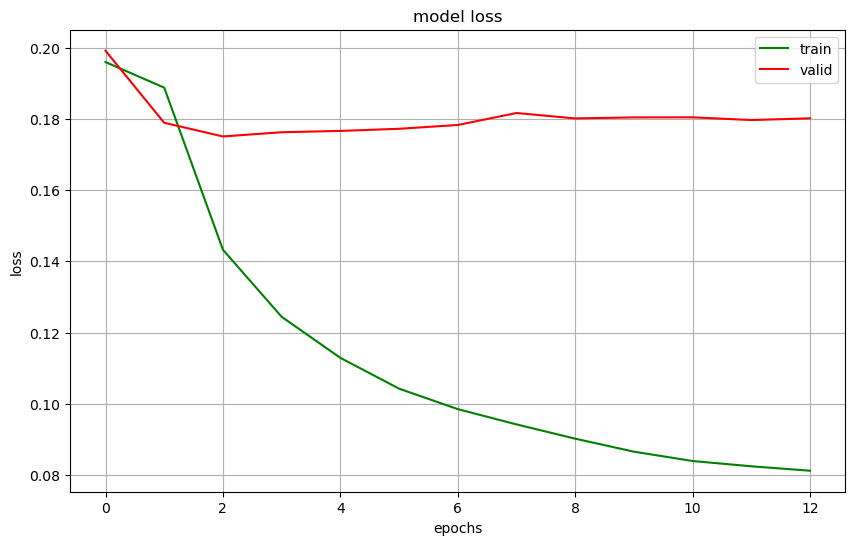

In [111]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.grid(True)
plt.show()

Можно сделать вывод, что модель обучается довольно быстро, однако ошибка на отложенной выборке высока - в среднем $ MAE = 0.18$. Т.к. оценки нормируются и респределены от 0 до 1, то ошибка составляет в среднем 18%. 

**Плюсы модели**:
* Простота
* Быстрота обучения

**Минусы**:
* Низкая точность
* Склонность к перообучению

## Модель с эмбеддингами на основе жанров

In [25]:
def features_embedding_model(num_users, num_movies, rows_count, text_emb_size, emb_size):
    n_genres = 20
    n_features = 4

    movie_features_input = keras.Input(shape=(n_genres+n_features,), name='movie_features')    
    movie_vec = layers.Dense(emb_size, activation='relu', name='movie_vec')(movie_features_input)
    movie_model = keras.Model(inputs= movie_features_input, outputs=movie_vec)

    user_input = keras.Input(shape=(1,), name='user_id')
    user_emb = layers.Embedding(output_dim=emb_size, input_dim=num_users+1, input_length=rows_count+1, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='user_emb_flatten')(user_emb)
    user_model = keras.Model(inputs=user_input, outputs=user_vec)

    merged = layers.Dot(name = 'dot_product', normalize = True, axes=1)([movie_vec, user_vec])
    merged_dropout = layers.Dropout(0.2)(merged)

    dense_1 = layers.Dense(256,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(128,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(32,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(8,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="sigmoid")(dense_4)

    adam = Adam(learning_rate=0.001)
    model = keras.Model([movie_features_input, user_input], result)
    model.compile(optimizer=adam, loss= 'mean_absolute_error', metrics='mean_squared_error')
    return movie_model, user_model, model

In [26]:
feat_movie_model, feat_user_model, feat_model = features_embedding_model(X.userId.nunique(), movies_df.index.max(), ratings_df.shape[0], 16, 32)

**Схема модели фильма**

<div>
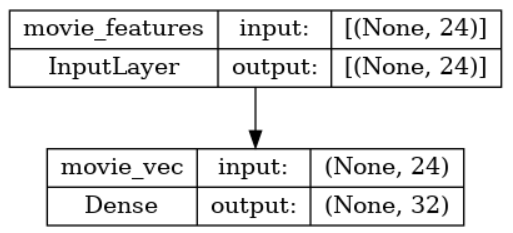
</div>


Модель получает на вход параметры фильма: жанры фильма, год выпуска, средняя оценка, отклонение оценок, количество оценок. Вектор из параметров проходит через полносвязный слой, на выходе получается векторное представление фильма

**Полная схема модели**

<div>
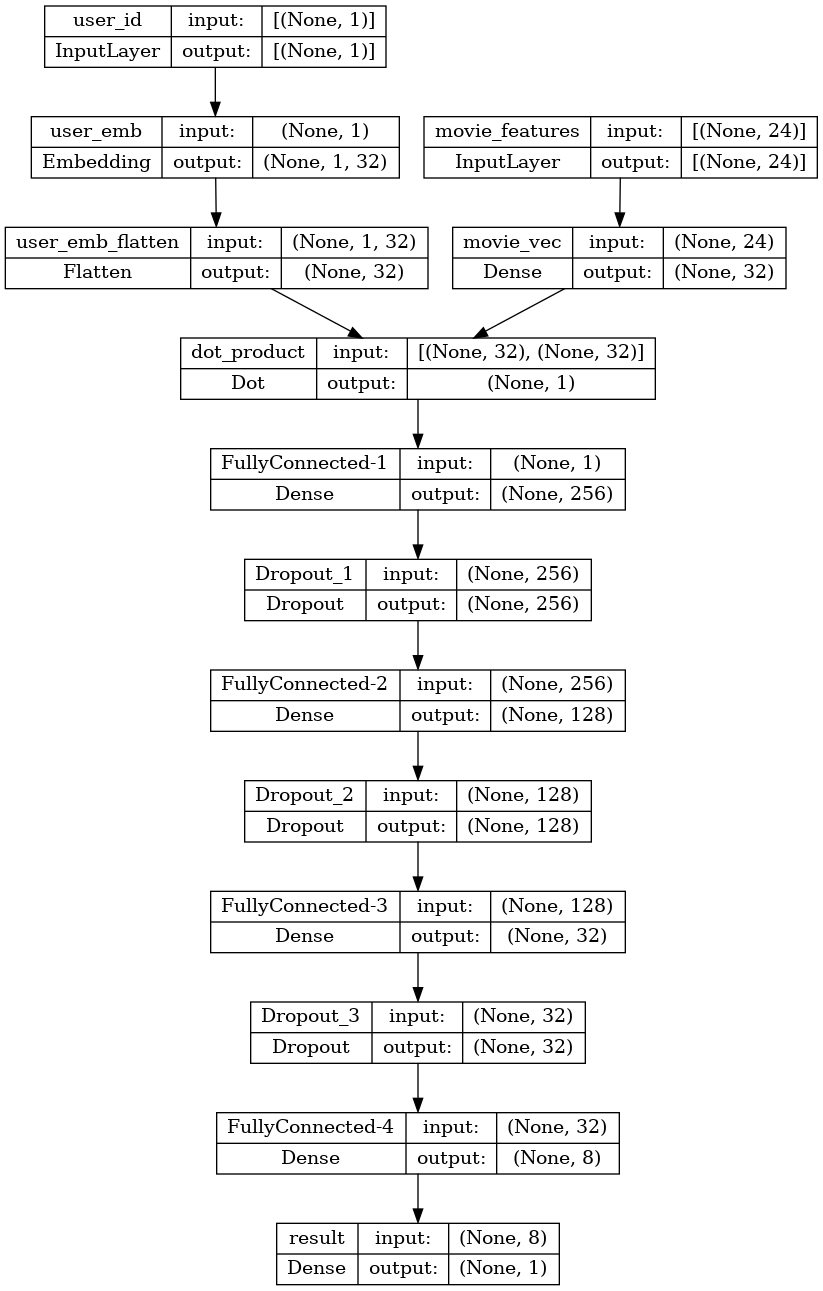
</div>


При помощи модели для фильмов создаётся векторное представление для фильма. Для пользователя обучается эмбеддинг. Векторы перемножаются скалярно, а затем применяется 4 полносвязных слоя с дропаутом. Количество нейронов слоях было увеличено по сравнению с предыдущей моделью т.к. теперь векторное представление фильма устроено сложнее

In [28]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('models/features/model/besttest.h5', save_best_only=True)]

f_history = feat_model.fit([X_train.drop(['userId', 'movieId'], axis=1), X_train['userId']], y_train, batch_size=100,
                              epochs=100, validation_data=([X_valid.drop(['userId', 'movieId'], axis=1), X_valid['userId']], y_valid),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/100
900/900 [==============================] - 7s 5ms/step - loss: 0.1777 - mean_squared_error: 0.0545 - val_loss: 0.1695 - val_mean_squared_error: 0.0498
Epoch 2/100
900/900 [==============================] - 4s 5ms/step - loss: 0.1696 - mean_squared_error: 0.0512 - val_loss: 0.1671 - val_mean_squared_error: 0.0494
Epoch 3/100
900/900 [==============================] - 4s 5ms/step - loss: 0.1679 - mean_squared_error: 0.0506 - val_loss: 0.1656 - val_mean_squared_error: 0.0501
Epoch 4/100
900/900 [==============================] - 4s 5ms/step - loss: 0.1671 - mean_squared_error: 0.0503 - val_loss: 0.1654 - val_mean_squared_error: 0.0492
Epoch 5/100
900/900 [==============================] - 4s 5ms/step - loss: 0.1664 - mean_squared_error: 0.0501 - val_loss: 0.1657 - val_mean_squared_error: 0.0501
Epoch 6/100
900/900 [==============================] - 4s 4ms/step - loss: 0.1658 - mean_squared_error: 0.0500 - val_loss: 0.1652 - val_mean_squared_error: 0.0493
Epoch 7/100
900/900 [=

Epoch 51/100
900/900 [==============================] - 4s 4ms/step - loss: 0.1508 - mean_squared_error: 0.0439 - val_loss: 0.1579 - val_mean_squared_error: 0.0452
Epoch 52/100
900/900 [==============================] - 4s 4ms/step - loss: 0.1500 - mean_squared_error: 0.0436 - val_loss: 0.1566 - val_mean_squared_error: 0.0449
Epoch 53/100
900/900 [==============================] - 4s 4ms/step - loss: 0.1495 - mean_squared_error: 0.0433 - val_loss: 0.1579 - val_mean_squared_error: 0.0452
Epoch 54/100
900/900 [==============================] - 4s 5ms/step - loss: 0.1497 - mean_squared_error: 0.0434 - val_loss: 0.1561 - val_mean_squared_error: 0.0448
Epoch 55/100
900/900 [==============================] - 4s 4ms/step - loss: 0.1494 - mean_squared_error: 0.0432 - val_loss: 0.1576 - val_mean_squared_error: 0.0454
Epoch 56/100
900/900 [==============================] - 4s 4ms/step - loss: 0.1495 - mean_squared_error: 0.0432 - val_loss: 0.1581 - val_mean_squared_error: 0.0454
Epoch 57/100
900

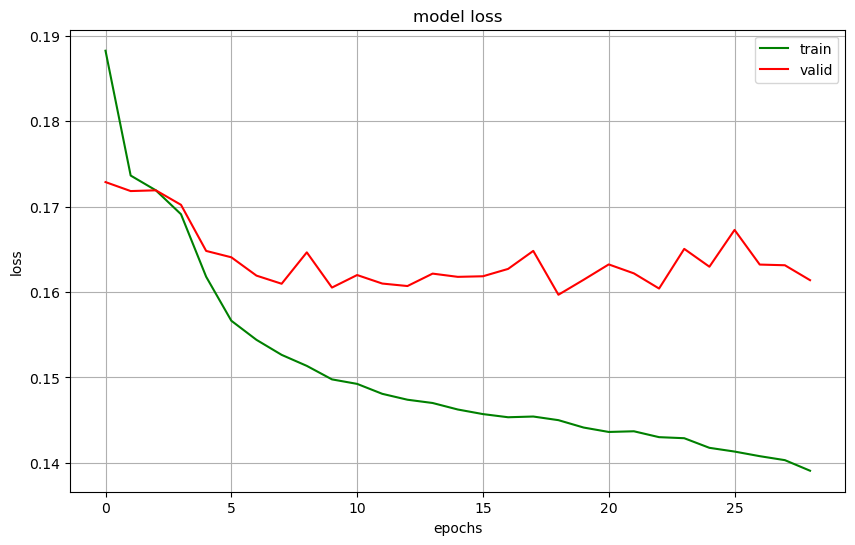

In [112]:
plt.figure(figsize=(10,6))
plt.plot(f_history.history['loss'] , 'g')
plt.plot(f_history.history['val_loss'] , 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.grid(True)
plt.show()

Можно заметить, что на валидацонной выборке ошибка уменьшилась (теперь она порядка 0.15-0.16). По сравнению с предыдущей моделью, удалось уменьшить ошибку на отложенной выборке. Такой подход кажется более естественным, т.к. используется не просто порядковый номер фильма, а его параметры

**Плюсы модели**:
* Использует признаки фильмов
* Работает точнее
* Обучается быстрее

**Минусы**:
* Усложнилась архитектура модели фильма
* Требуется больше эпох

## Encoder для тегов фильма

In [19]:
def encoder_model(num_users, n_genome, rows_count, emb_size):
    autoencoder_input = Input(shape=(n_genome,), name='autoencoder_input')
    encoder_dense_1 = layers.Dense(512, name='EncoderDense-1')(autoencoder_input)
    encoder_dense_2 = layers.Dense(256, name='EncoderDense-2')(encoder_dense_1)
    encoder_dense_3 = layers.Dense(128, name='EncoderDense-3')(encoder_dense_2)
    encoder_dense_4 = layers.Dense(emb_size, name='EncoderDense-4')(encoder_dense_3)
    
    decoder_dense_1 = layers.Dense(128,name='DecoderDense-1')(encoder_dense_4)
    decoder_dense_2 = layers.Dense(256,name='DecoderDense-2')(decoder_dense_1)
    decoder_dense_3 = layers.Dense(512,name='DecoderDense-3')(decoder_dense_2)
    decoder_dense_4 = layers.Dense(n_genome,name='DecoderDense-4')(decoder_dense_3)
    
    encoder = Model(inputs=autoencoder_input, outputs=encoder_dense_4)
    decoder = Model(inputs=encoder_dense_4, outputs=decoder_dense_4)
    autoencoder = Model(inputs=autoencoder_input, outputs=decoder_dense_4)
    
    adam = keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=adam, loss= 'mean_absolute_error', metrics='mean_squared_error')

    user_input = keras.Input(shape=(1,), name='user_id')
    user_emb = layers.Embedding(output_dim=emb_size, input_dim=num_users+1, input_length=rows_count+1, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='user_emb_flatten')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)

    merged = layers.Dot(name = 'dot_product', normalize = True, axes=1)([encoder_dense_4, user_vec])
    merged_dropout = layers.Dropout(0.2)(merged)


    dense_1 = layers.Dense(256,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout-1')(dense_1)

    dense_2 = layers.Dense(128,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout-2')(dense_2)

    dense_3 = keras.layers.Dense(32,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout-3')(dense_3)

    dense_4 = keras.layers.Dense(8,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="sigmoid")(dense_4)

    model = keras.Model([autoencoder_input, user_input], result)
    model.compile(optimizer=adam, loss= 'mean_absolute_error', metrics='mean_squared_error')
    return encoder, decoder, autoencoder, user_model, model

In [48]:
encoder, decoder, autoencoder, enc_user_model, enc_model = encoder_model(X.userId.nunique(), genome.shape[1], X.shape[0], 64)

**Cхема автоэнкодера**

<div>
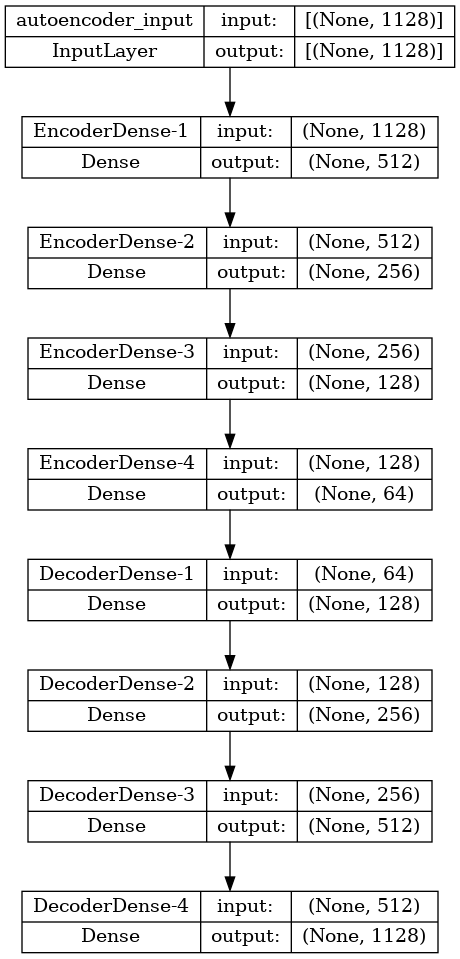
</div>

Идея состоит в том, чтобы использовать датасет *genome*. В нём даны темы фильмов и релеватность каждого фильма каждой теме. Такие векторы можно использовать для определения схожести фильмов: похожие фильмы имеют похожие темы. Проблема заключается в том, что многие темы похожи, а самих тем довольно много. Можно обучить автоэнкодер для уменьшения размерности вектора с темами, а затем использовать энкодер для создания векторных представлений фильмов

**Полная схема модели**

<div>
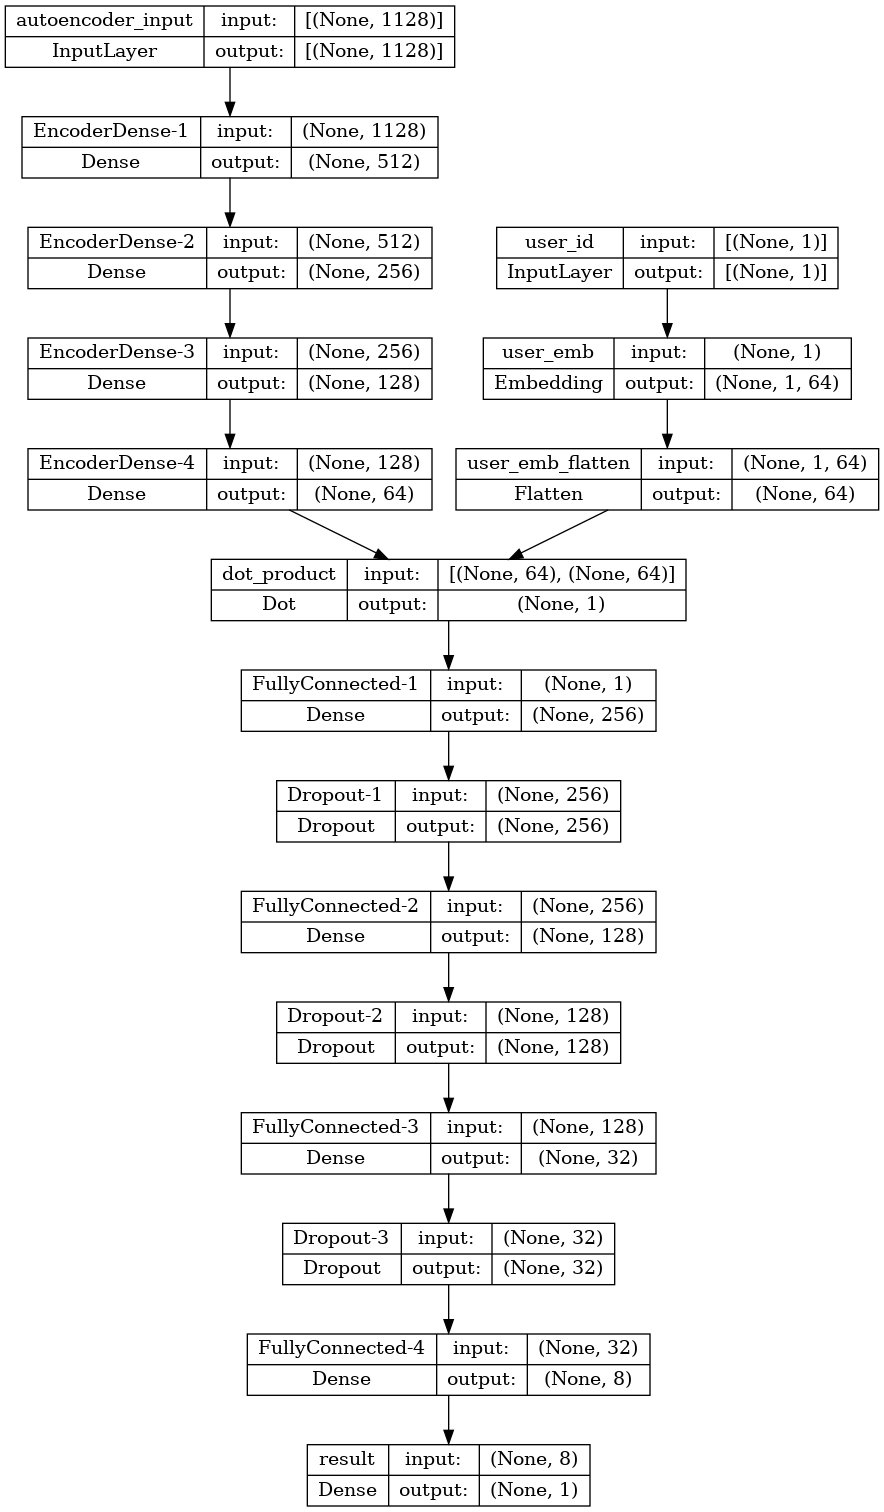
</div>

Фильмы кодируются с помощью энкодера тематик, а для пользователя создаётся эмбеддинг. Также был увеличен размер эмбеддингов.

Обучение энкодера

In [49]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('models/features/model/besttesttt.h5', save_best_only=True)]

encoder_history = autoencoder.fit(X_train_autoenc, X_train_autoenc, batch_size=100,
                              epochs=100, validation_data=(X_valid_autoenc, X_valid_autoenc),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/100
119/119 [==============================] - 5s 33ms/step - loss: 0.0673 - mean_squared_error: 0.0176 - val_loss: 0.0461 - val_mean_squared_error: 0.0099
Epoch 2/100
119/119 [==============================] - 3s 25ms/step - loss: 0.0432 - mean_squared_error: 0.0087 - val_loss: 0.0411 - val_mean_squared_error: 0.0079
Epoch 3/100
119/119 [==============================] - 3s 25ms/step - loss: 0.0399 - mean_squared_error: 0.0074 - val_loss: 0.0391 - val_mean_squared_error: 0.0072
Epoch 4/100
119/119 [==============================] - 3s 26ms/step - loss: 0.0383 - mean_squared_error: 0.0068 - val_loss: 0.0379 - val_mean_squared_error: 0.0066
Epoch 5/100
119/119 [==============================] - 4s 30ms/step - loss: 0.0373 - mean_squared_error: 0.0064 - val_loss: 0.0369 - val_mean_squared_error: 0.0064
Epoch 6/100
119/119 [==============================] - 4s 31ms/step - loss: 0.0367 - mean_squared_error: 0.0062 - val_loss: 0.0369 - val_mean_squared_error: 0.0063
Epoch 7/100
119/

Обучение модели

In [18]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('models/features/model/besttesttt.h5', save_best_only=True)]

encoder_f_history = enc_model.fit([X_train_genome.drop(['userId', 'movieId'], axis=1), X_train_genome['userId']], y_train_genome, batch_size=200,
                              epochs=50, validation_data=([X_valid_genome.drop(['userId', 'movieId'], axis=1), X_valid_genome['userId']], y_valid_genome),
                              verbose=1,
                              callbacks = callbacks)

Epoch 1/50
447/447 [==============================] - 13s 23ms/step - loss: 0.1638 - mean_squared_error: 0.0472 - val_loss: 0.1512 - val_mean_squared_error: 0.0400
Epoch 2/50
447/447 [==============================] - 9s 21ms/step - loss: 0.1483 - mean_squared_error: 0.0395 - val_loss: 0.1467 - val_mean_squared_error: 0.0384
Epoch 3/50
447/447 [==============================] - 10s 22ms/step - loss: 0.1430 - mean_squared_error: 0.0373 - val_loss: 0.1447 - val_mean_squared_error: 0.0380
Epoch 4/50
447/447 [==============================] - 10s 21ms/step - loss: 0.1405 - mean_squared_error: 0.0362 - val_loss: 0.1436 - val_mean_squared_error: 0.0373
Epoch 5/50
447/447 [==============================] - 10s 22ms/step - loss: 0.1384 - mean_squared_error: 0.0355 - val_loss: 0.1432 - val_mean_squared_error: 0.0371
Epoch 6/50
447/447 [==============================] - 10s 22ms/step - loss: 0.1366 - mean_squared_error: 0.0348 - val_loss: 0.1421 - val_mean_squared_error: 0.0368
Epoch 7/50
447/44

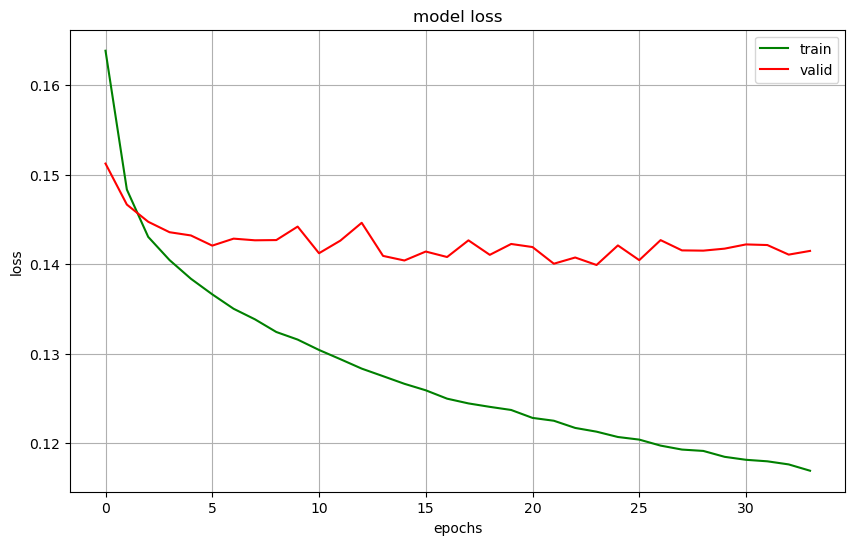

In [23]:
plt.figure(figsize=(10,6))
plt.plot(encoder_f_history.history['loss'] , 'g')
plt.plot(encoder_f_history.history['val_loss'] , 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='upper right')
plt.grid(True)
plt.show()

Можно заметить, что удалось достигнуть ещё более низкой ошибки. Однако, в датасете *genome* представлены не вске фильмы, из-за чего размер выборок уменьшается и не все фильмы можно будет закодировать при помощи этой модели 

**Плюсы модели**:
* Использует признаки фильмов
* Работает точнее

**Минусы**:
* Много слоёв и параметров
* Ограничения из-за количества фильмов в датасете

Можно сделать вывод, что из представленных моделей целесообразнее использовать модель с эмбеддингом на основе признаков фильма

## Сохранение моделей

In [114]:
id_model.save('models/id/model')
id_movie_model.save('models/id/movie_model')
id_user_model.save('models/id/user_model')

INFO:tensorflow:Assets written to: models/id/model\assets


INFO:tensorflow:Assets written to: models/id/model\assets


INFO:tensorflow:Assets written to: models/id/movie_model\assets


INFO:tensorflow:Assets written to: models/id/movie_model\assets


INFO:tensorflow:Assets written to: models/id/user_model\assets


INFO:tensorflow:Assets written to: models/id/user_model\assets


In [115]:
feat_model.save('models/features/model')
feat_movie_model.save('models/features/movie_model')
feat_user_model.save('models/features/user_model')

INFO:tensorflow:Assets written to: models/features/model\assets


INFO:tensorflow:Assets written to: models/features/model\assets


INFO:tensorflow:Assets written to: models/features/movie_model\assets


INFO:tensorflow:Assets written to: models/features/movie_model\assets


INFO:tensorflow:Assets written to: models/features/user_model\assets


INFO:tensorflow:Assets written to: models/features/user_model\assets


In [ ]:
feat_model.save('models/features/model')
feat_movie_model.save('models/features/movie_model')
feat_user_model.save('models/features/user_model')